In [1]:
# 핵심 패키지(스트리밍 호환 버전)
!pip -q install "datasets<3.0.0" "evaluate<0.5.0" "transformers>=4.38,<4.45" \
                huggingface_hub torchaudio jiwer soundfile

# fsspec/gcsfs 충돌 정리
!pip -q install -U fsspec==2025.3.0 gcsfs

import datasets, evaluate, transformers, fsspec, gcsfs, sys
print("datasets:", datasets.__version__)    # ← 2.x 여야 OK
print("evaluate:", evaluate.__version__)    # ← 0.4.x 권장
print("transformers:", transformers.__version__)
print("fsspec:", fsspec.__version__)
print("gcsfs:", gcsfs.__version__)
print("python:", sys.version)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 99.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
from datasets import load_dataset, Audio, Dataset, load_from_disk
from transformers import WhisperProcessor, WhisperForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from evaluate import load
import random
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union
from evaluate import load as load_metric
import pandas as pd
import numpy as np

# 2) 재현성 고정
import os, random, numpy as np, torch
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# 결정적 연산(권장)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Seed fixed to {}.".format(SEED))

Seed fixed to 42.


In [5]:
n_train = 200
n_val   = 100
n_test  = 100

langs = ["ko", "ja", "en", "de"]

# =========================================================
# (중요) 고정 split만 로드: 증강 실험과 동일 테스트셋 사용
# =========================================================
SPLIT_DIR = "/content/drive/MyDrive/data/asr_splits/cv16_v1"  # 네가 저장해 둔 경로
required = ["train","val","test"]
if not (os.path.isdir(SPLIT_DIR) and all(os.path.isdir(os.path.join(SPLIT_DIR, d)) for d in required)):
    raise RuntimeError(f"[STOP] Fixed splits not found under {SPLIT_DIR} (need subdirs: train/ val/ test/).")

print("✅ Loading fixed splits from disk:", SPLIT_DIR)
train_dataset = load_from_disk(os.path.join(SPLIT_DIR, "train"))
val_dataset   = load_from_disk(os.path.join(SPLIT_DIR, "val"))
test_dataset  = load_from_disk(os.path.join(SPLIT_DIR, "test"))
print({ "train": len(train_dataset), "val": len(val_dataset), "test": len(test_dataset) })

✅ Loading fixed splits from disk: /content/drive/MyDrive/data/asr_splits/cv16_v1
{'train': 800, 'val': 400, 'test': 400}


In [6]:
model_checkpoint = "openai/whisper-small"

processor = WhisperProcessor.from_pretrained(model_checkpoint)
feature_extractor = processor.feature_extractor
tokenizer = processor.tokenizer

# 16kHz 캐스팅
train_dataset = train_dataset.cast_column("audio", Audio(sampling_rate=16000))
val_dataset   = val_dataset.cast_column("audio",   Audio(sampling_rate=16000))
test_dataset  = test_dataset.cast_column("audio",  Audio(sampling_rate=16000))

def prepare_dataset(example):
    audio = example["audio"]
    example["input_features"] = processor.feature_extractor(
        audio["array"], sampling_rate=16000
    ).input_features[0]
    example["labels"] = processor.tokenizer(example["sentence"]).input_ids
    return example

keep_cols = {"input_features", "labels", "locale"}

processed_dataset_train = train_dataset.map(
    prepare_dataset,
    remove_columns=[c for c in train_dataset.column_names if c not in keep_cols]
)
processed_dataset_val = val_dataset.map(
    prepare_dataset,
    remove_columns=[c for c in val_dataset.column_names if c not in keep_cols]
)
processed_dataset_test = test_dataset.map(
    prepare_dataset,
    remove_columns=[c for c in test_dataset.column_names if c not in keep_cols]
)

processed_dataset_train.set_format(columns=["input_features", "labels", "locale"])
processed_dataset_val.set_format(columns=["input_features", "labels", "locale"])
processed_dataset_test.set_format(columns=["input_features", "labels", "locale"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [7]:
import torch
from torch import nn
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(model_checkpoint)
# 학습 중 캐시 비활성(메모리/안정성)
model.config.use_cache = False
# 평가 때 경고 줄이기용(안전)
start_id = processor.tokenizer.convert_tokens_to_ids("<|startoftranscript|>")
model.config.decoder_start_token_id = start_id
model.generation_config.decoder_start_token_id = start_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.generation_config.pad_token_id = processor.tokenizer.pad_token_id
# 학습 중 언어 강제 OFF (평가 시만 ON)
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

from dataclasses import dataclass

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    padding: Union[bool, str] = True
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": f["input_features"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-finetuned",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    num_train_epochs=3,
    logging_steps=10,
    save_steps=50,
    fp16=torch.cuda.is_available(),
    report_to="none",

    predict_with_generate=True,    # ★ generate() 기반 평가
    generation_max_length=225,
    # 아래 3개 켜면 epoch별 평가/저장/베스트모델 사용 가능(그래프용)
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,

    remove_unused_columns=False,   # input_features 보존
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset_train,
    eval_dataset=processed_dataset_val,   # ← 학습 중 평가는 여전히 VAL
    tokenizer=processor,
    data_collator=data_collator,
)

trainer.train()

trainer.save_model("./whisper-small-finetuned")
processor.save_pretrained("./whisper-small-finetuned")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.627900,0.626048
2,0.134800,0.616272
3,0.032500,0.618760


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-cust

[]

In [8]:
test_ko = processed_dataset_test.filter(lambda x: x["locale"] == "ko")
test_en = processed_dataset_test.filter(lambda x: x["locale"] == "en")
test_ja = processed_dataset_test.filter(lambda x: x["locale"] == "ja")
test_de = processed_dataset_test.filter(lambda x: x["locale"] == "de")

lang_datasets = {"ko": test_ko, "en": test_en, "ja": test_ja, "de": test_de}
print("🔎 Evaluating on: TEST split (fixed)")

wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

LANG_NAME = {"ko":"korean", "ja":"japanese", "en":"english", "de":"german"}

lang_scores = {}
for lang, dataset in lang_datasets.items():
    print(f"\n🌍 Language: {lang.upper()}")
    # 언어 강제 프롬프트 → 인퍼런스 안정화
    forced_ids = processor.get_decoder_prompt_ids(language=LANG_NAME[lang], task="transcribe")
    trainer.model.generation_config.forced_decoder_ids = forced_ids
    trainer.model.generation_config.max_length = 225

    pred_output = trainer.predict(dataset)  # generate 결과 반환
    decoded_preds = processor.tokenizer.batch_decode(pred_output.predictions, skip_special_tokens=True)
    decoded_labels = processor.tokenizer.batch_decode(pred_output.label_ids,   skip_special_tokens=True)

    # 샘플 출력
    for p, r in list(zip(decoded_preds, decoded_labels))[:3]:
        print(f"🔹Pred: {p}\n🔸Ref : {r}\n---")

    wer_score = wer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    cer_score = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    lang_scores[lang] = {"WER": wer_score, "CER": cer_score, "N": len(decoded_labels)}

    print(f"✅ {lang.upper()} WER: {wer_score:.4f}")
    print(f"✅ {lang.upper()} CER: {cer_score:.4f}")

import pandas as pd
df_base = pd.DataFrame(
    [{"lang": k, "WER": v["WER"], "CER": v["CER"], "N": v["N"]} for k, v in lang_scores.items()]
).sort_values("lang")
display(df_base)
df_base.to_csv("/content/baseline_cv16_1_whisper_small_FIXEDSPLIT_TEST.csv", index=False)
print("Saved -> /content/baseline_cv16_1_whisper_small_FIXEDSPLIT_TEST.csv")

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

🔎 Evaluating on: TEST split (fixed)



🌍 Language: KO


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


🔹Pred: 그러나 실제로 뽑은 숫자는 지난주에 미치지 못한 것으로 나타났다.
🔸Ref : 그러나 실제로 뽑은 숫자는 지난 주에 미치지 못한 것으로 나타났다.
---
🔹Pred: 신압대는 이렇게 말하며 유서방을 견눈질해보았다.
🔸Ref : 싱앗대는 이렇게 말하며 유서방을 곁눈질해 보았다.
---
🔹Pred: 신철이는 어찌 보면 감정을 가진 사람같지 않아 보였다.
🔸Ref : 신철이는 어찌 보면 감정을 가진 사람 같지 않아 보였다.
---
✅ KO WER: 0.4166
✅ KO CER: 0.1624

🌍 Language: EN


🔹Pred: A lot of the area belonged to the class of the notes known as the Bore-Modernia-Berts-Hepernitska.
🔸Ref : Enoxaparin belongs to the class of drugs known as low molecular weight heparins.
---
🔹Pred: Eight.
🔸Ref : eight
---
🔹Pred: Do you read it?
🔸Ref : Do you mean it?
---
✅ EN WER: 0.2615
✅ EN CER: 0.1268

🌍 Language: JA


🔹Pred: 福島県広野町
🔸Ref : 福島県広野町
---
🔹Pred: だが言わる
🔸Ref : だが断る
---
🔹Pred: そして、いくら見舞いとしても、君が悪ければ悪いほど書いてその紙をじっと見つめないではいられませんでした。
🔸Ref : そして、いくら見まいとしても、きみが悪ければ悪いほど、かえってその影を、じっと見つめないではいられませんでした。
---
✅ JA WER: 0.9099
✅ JA CER: 0.5214

🌍 Language: DE


🔹Pred: Wenn nicht, dann läckt man sie irgendwo hin, woplatz ist.
🔸Ref : Wenn nicht, dann legt man sie irgendwo hin, wo Platz ist.
---
🔹Pred: Wie ist die derzeitige Verkehrssituation?
🔸Ref : Wie ist die derzeitige Verkehrssituation?
---
🔹Pred: Auch den Prozesse haben wir Hexen, Verfolgungen und Kamerotenten, die scheren Räte bekommen.
🔸Ref : Aus den Prozessakten der Hexenverfolgung sind keine authentischen Rezepte bekannt.
---
✅ DE WER: 0.3302
✅ DE CER: 0.1264


,lang,WER,CER,N
3,de,0.330155,0.126393,100
1,en,0.261453,0.126777,100
2,ja,0.909910,0.521359,100
0,ko,0.416555,0.162438,100


Saved -> /content/baseline_cv16_1_whisper_small_FIXEDSPLIT_TEST.csv


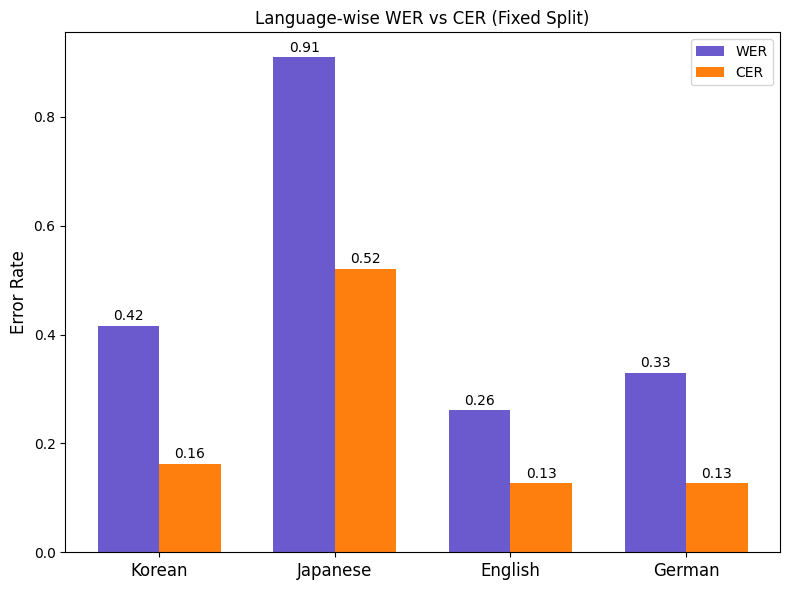

In [9]:
# 시각화
import matplotlib.pyplot as plt

languages = ["Korean", "Japanese", "English", "German"]
wer = [df_base[df_base["lang"]==k]["WER"].values[0] for k in ["ko","ja","en","de"]]
cer = [df_base[df_base["lang"]==k]["CER"].values[0] for k in ["ko","ja","en","de"]]

x = np.arange(len(languages))  # 언어 개수만큼 위치
width = 0.35  # 막대 너비

plt.figure(figsize=(8,6))
plt.bar(x - width/2, wer, width, label="WER", color="#6A5ACD")
plt.bar(x + width/2, cer, width, label="CER", color="#ff7f0e")
plt.xticks(x, languages, fontsize=12)
plt.ylabel("Error Rate", fontsize=12)
plt.title("Language-wise WER vs CER (Fixed Split)")
plt.legend()
for i in range(len(languages)):
    plt.text(x[i] - width/2, wer[i] + 0.01, f"{wer[i]:.2f}", ha="center", fontsize=10)
    plt.text(x[i] + width/2, cer[i] + 0.01, f"{cer[i]:.2f}", ha="center", fontsize=10)
plt.tight_layout()
plt.show()